<a href="https://colab.research.google.com/github/aniilkeles/DeepLearningNotes/blob/main/GAN's/PyTorch_GAN's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code requires a GPU to run, as GANs need GPU acceleration for efficient training.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [4]:
batch_size = 128
image_size = 28*28
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

In [5]:
dataset = datasets.MNIST(root="./data",train=True,transform=transform,download=True)

dataLoader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [6]:
from torch.nn.modules.activation import LeakyReLU
# Discriminator
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator,self).__init__()
    self.model = nn.Sequential(  # Sequential bir base base içerisine aldığı her bir neural network bileşeni birbirine sıralı olarak bağlı olacak.
        nn.Linear(image_size,1024), # 1024 nöron sayısı bu layer'ın outputu
        nn.LeakyReLU(0.2), # eğim parametresi => 0.2
        nn.Linear(1024,512), # 1024 ' ten 512 düğüme
        nn.LeakyReLU(0.2),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,1), # output layer => gerçek ya da sahte sınıflandırma yapacak yani binary classification olacak
        nn.Sigmoid() # Sigmoid aktivasyonu discriminator'un çıktısının gerçek mi sahte mi olduğunu olasılıksal olarak söyler ve outputu 0 ve 1 arasına getirir.
    )
# sigmoid genelde sınıflandırma problemlerinde kullanılır.
  def forward(self,img):
    return self.model(img.view(-1,image_size)) # => örnek olarak [128,784] ayarlanabilir.Görüntüyü düzleştirirek modele verir.

In [7]:
# Generator

class Generator(nn.Module): # görüntü(28*28*1) oluşturmak

  def __init__(self,z_dim):
    super(Generator,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(z_dim,256), # z_dim=> giriş boyutu , girişten 256 düğüme tam bağlı katman
        nn.ReLU(),
        nn.Linear(256,512), # 256 düğümden 512 düğüme
        nn.ReLU(),
        nn.Linear(512,1024),
        nn.ReLU(),
        nn.Linear(1024,image_size), # 1024 ten image_size(28*28=784) 784 e çevrim işlemi
        nn.Tanh() # çıkış aktivasyon fonksiyonu
    )
# Tanj kullanmamızın nedeni input verisi olarak 28*28 lik -1 ve 1 arasına sıkıştırılmış piksel değerlerinden oluşan bir input veriyoruz bu nedenle generatorda onu üretmeli

  def forward(self,x):
    return self.model(x).view(-1,1,28,28) # -1 batchsize kadar veri olacak onu kendi belirleyecek.

In [8]:
# GAN Training

In [11]:
#hyperparameters
lr = 0.0002
z_dim = 100 # rastgele gürültü vektör boyutu.Biz burda illa 28*28 lik olarak boyutunda seçmek zorunda değiliz.(noise) görüntüsü
epochs = 20
# model tanımlama : generator ve discrimanator tanımlayacağım
generator = Generator(z_dim)
discriminator = Discriminator()
# kayıp fonksiyonu ve optimizasyon algoritmalarının tanımlanması
criterion = nn.BCELoss() # Cross entropy algoritması ama binary yaptığımızı belirtiyoruz.
g_optimizer = optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))# Optimizer olarak 2 tane belirleyeceğiz iki tane nn var. betas learning rate'in değişme hızını belirler.
d_optimizer = optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
# eğitim döngüsünün başlatılması
for epoch in range(epochs):
  # görüntülerin yüklenmesi
  for i,(real_imgs,_) in enumerate(dataLoader): # burda yaptığımız şey dataloader'ı enumerate'e aldık hem görüntüyü hemde görüntüye karşılık gelen indeksi return edecektir.İndex i parametresi return edecek görüntü ve görüntünün etiketlerini bir tuple olarak belirledim.
    batch_size = real_imgs.size(0) # real_imgs batchler halinde gelecek [128,1,28,28] gibi bu 128 i alabilmemiz için 0 yazmamız gerekir.
    real_labels = torch.ones(batch_size,1) # real_labels 1 lerden oluşan bir vektör olsun dedim yani gerçek görüntüleri 1 olarak etiketle
    fake_labels = torch.zeros(batch_size,1) # fake görüntüleri 0 olarak etiketle
  # discriminator eğitilmesi
    z = torch.randn(batch_size,z_dim)  # rastgele gürültü üret
    fake_imgs = generator(z) # generator ile sahte görüntü oluşturma
    real_loss = criterion(discriminator(real_imgs),real_labels) # gerçek görüntü kaybı
    fake_loss = criterion(discriminator(fake_imgs.detach()),fake_labels) # sahte görüntülerin kaybı
    d_loss = real_loss + fake_loss # toplam discriminator kaybı

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

  # generator eğitilmesi

    g_loss = criterion(discriminator(fake_imgs),real_labels)
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


  print(f"Epoch {epoch+1}/{epochs} , Discriminator Loss : {d_loss.item():.3f} , Generator Loss : {g_loss.item():.3f}")

Epoch 1/20 , Discriminator Loss : 0.304 , Generator Loss : 5.450


KeyboardInterrupt: 

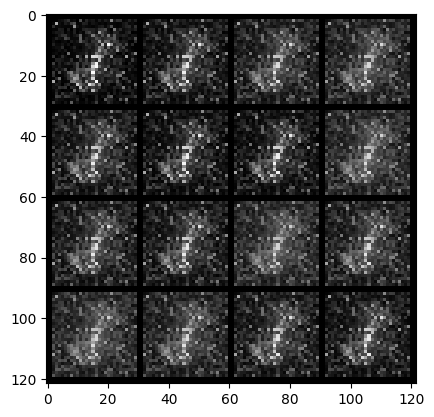

In [12]:
# rastgele gürültü ile görüntü oluşturma
with torch.no_grad():
  z = torch.randn(16,z_dim) # 16 adet rastgele görüntü oluşturma
  sample_imgs = generator(z).cpu() # generator ile sahte görüntü oluşturma
  grid = np.transpose(utils.make_grid(sample_imgs,nrow=4,normalize=True),(1,2,0)) # görüntüleri ızgara şeklinde düzenlemek
  plt.imshow(grid)
  plt.show()